# regrid the dataset to a healpix grid

Since the default geographic rectilinear grid has non-uniform grid sizes and distances and is thus not suitable for this application, we transform the dataset to one with equal distances between the cell centers. The Healpix cells satisfy these conditions, and can be used for spatial convolutions when reshaped to a 2D array according to the "nested" cell numbering.

As with any interpolation, the linear interpolation supported by the `healpy` library is split into the computation of weights and the application of those weights to the data.

In [1]:
import xarray as xr
#import hvplot.xarray
#import numpy as np
#import fsspec

#import warnings

#warnings.filterwarnings("ignore")
from xarray_healpy.grid import HealpyGridInfo
from xarray_healpy.regridder import HealpyRegridder

In [2]:
import xarray as xr
ds=xr.open_zarr(
    'https://data-taos.ifremer.fr/fish-intel/bugfixed_0/A19124/diff.zarr')
ds = (
    ds
#    .pipe(lambda ds: ds.merge(ds[["latitude", "longitude"]].compute()))
    .swap_dims({"lat": "yi", "lon": "xi"})
    .drop_vars(["lat", "lon"])[["H0","ocean_mask"]]
).compute()

In [3]:
ds

<xarray.Dataset>
Dimensions:     (yi: 371, xi: 231)
Coordinates:
    latitude    (yi, xi) float32 46.0 46.0 46.0 46.0 ... 51.0 51.0 51.0 51.0
    longitude   (yi, xi) float32 -8.0 -7.97 -7.939 ... -1.091 -1.061 -1.03
Dimensions without coordinates: yi, xi
Data variables:
    H0          (yi, xi) float32 4.849e+03 4.846e+03 4.842e+03 ... nan nan nan
    ocean_mask  (yi, xi) bool True True True True ... False False False False
Attributes:
    tag_id:   A19124

## regridding does not work, so i'll just select the 'zone' for spcifing the 'valid' data
#

In [7]:


def filter_ds(data_array):

    lat_min, lat_max = 47, 48
    lon_min, lon_max = -3, -2
    
    # Filter data based on latitude and longitude ranges
    filtered_data = data_array.where(
        (data_array.latitude >= lat_min) & (data_array.latitude <= lat_max) &
        (data_array.longitude >= lon_min) & (data_array.longitude <= lon_max),
        drop=True
    )

    return filtered_data


## If the valid data zone ( lon -3,-2, and lat 47 48) without rotation, and with rotation is about the same (for the same nside) rotation is not destroying the equaly size healpix property (which was destroyed with the old rotation definition...) 


In [5]:
rot = {"lat": 0, "lon": 0}
level=10

valid data number= <xarray.DataArray 'data' ()>
array(214)
Coordinates:
    resolution  float64 0.0009993
CPU times: user 23.1 s, sys: 1.4 s, total: 24.5 s
Wall time: 3.27 s


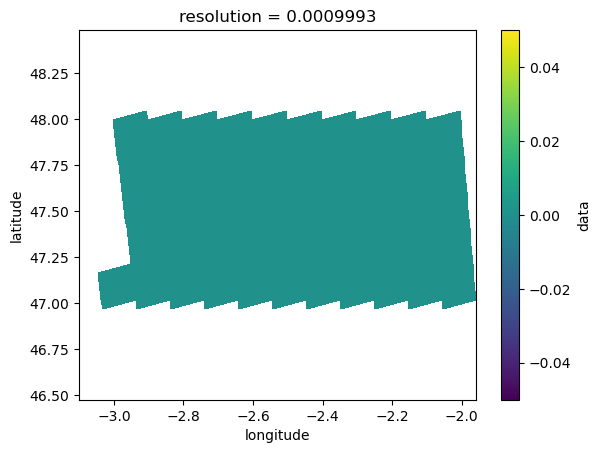

In [8]:
%%time

grid = HealpyGridInfo(level=level, rot=rot)
target_0 = grid.target_grid(ds)
data_0 = grid.to_2d(xr.zeros_like(target_0["longitude"]).rename("data"))

filterd_0=filter_ds(data_0)

print('valid data number=',filterd_0.count())
filterd_0.plot(y='latitude',x='longitude')

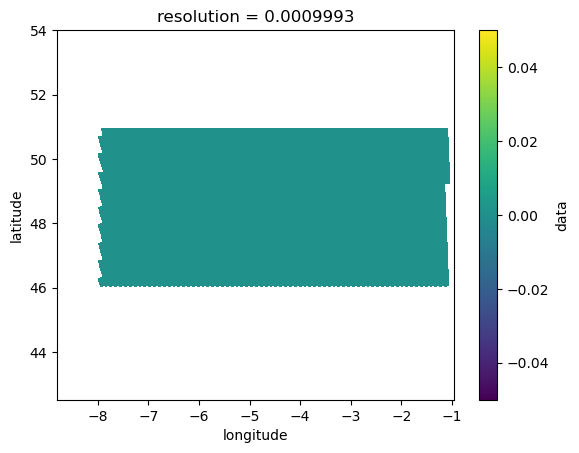

In [9]:
data_0.plot(y='latitude',x='longitude')

valid data number= <xarray.DataArray 'data' ()>
array(213)
Coordinates:
    resolution  float64 0.0009993


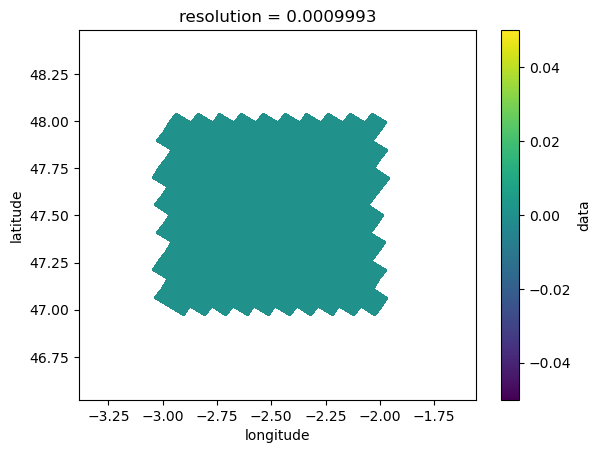

In [17]:
rot = {"lat": 60, "lon": 30}
rot = {"lat": 0, "lon": 30}
rot = {"lat": -30, "lon": 0}

#rot = {"lat": -30, "lon": 30}
#ValueError: can only reshape for a single base pixel for now. Data covers base pixels [0, 4].


grid = HealpyGridInfo(level=level, rot=rot)
target = grid.target_grid(ds)

data = grid.to_2d(xr.zeros_like(target["longitude"]).rename("data"))

filterd=filter_ds(data)

print('valid data number=',filterd.count())
filterd.plot(y='latitude',x='longitude')

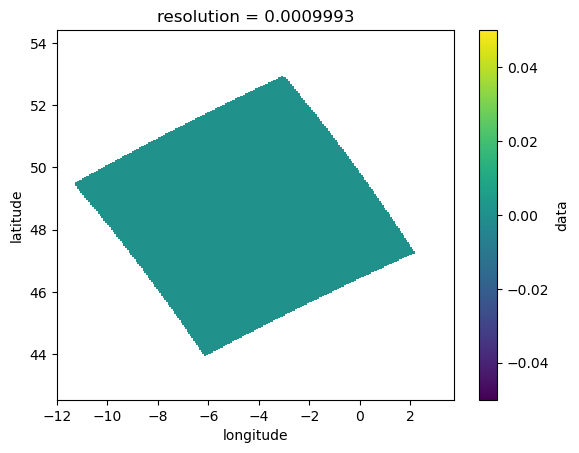

In [11]:
data.plot(y='latitude',x='longitude')

# Conclusion

The valid value is almost equal 
(nside=10,214, 206)

i.e. The grid is rotating well.  

##  test regridder 
HealpyRegridder crash with rotation.  

In [12]:
regridder = HealpyRegridder(
    ds[["longitude", "latitude", "ocean_mask"]],
    target_0,
    #method="bilinear",
    interpolation_kwargs={"mask": "ocean_mask",
                         # "min_vertices": min_vertices
                         },
)
regridder

/home/jovyan/xarray-healpy/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


HealpyRegridder(method='bilinear', interpolation_kwargs={'mask': 'ocean_mask'})

In [13]:
regridder = HealpyRegridder(
    ds[["longitude", "latitude", "ocean_mask"]],
    target,
    #method="bilinear",
    interpolation_kwargs={"mask": "ocean_mask",
                         # "min_vertices": min_vertices
                         },
)
regridder

ZeroDivisionError: division by zero